Dataset shape: (4999, 6)
Column list: Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Specialities: medical_specialty
Surgery                          1103
Consult - History and Phy.        516
Cardiovascular / Pulmonary        372
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  230
Neurology                         223
SOAP / Chart / Progress Notes     166
Obstetrics / Gynecology           160
Urology                           158
Discharge Summary                 108
ENT - Otolaryngology               98
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    62
Psychiatry / Psychology            53
O

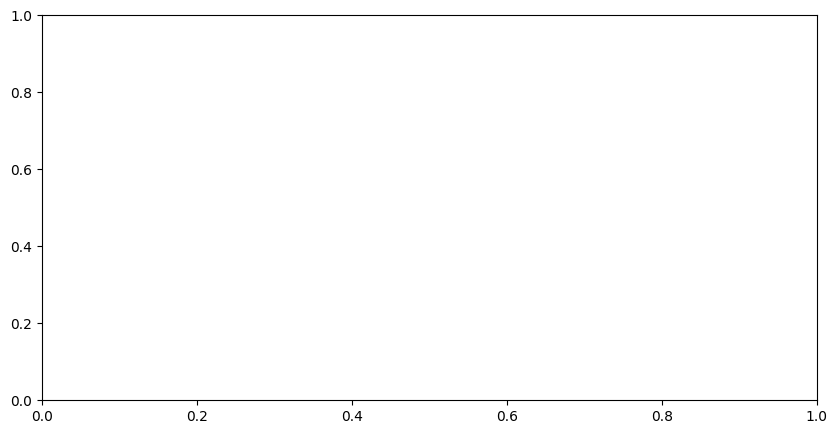

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

try:
    df = pd.read_csv('C:/Users/Admin/Documents/ResearchProject/mtsamples.csv')
    print(f'Dataset shape: {df.shape}')
    print(f'Column list: {df.columns}')
    df['transcription'] = df['transcription'].fillna('') #To handle missing values

    specialities = df['medical_specialty'].value_counts()
    print(f'Specialities: {specialities}')

    plt.figure(figsize=(10,5))
    specialities.plot(kind='bar', color='peach')
    plt.title("All medical specialities in the dataset")
    plt.ylabel("Number of Transcripts")
    plt.show()
    

except Exception as e:
    print("Error:", str(e))
    if 'df' in locals():
        print("\nAvailable specialties:", df['medical_specialty'].unique())

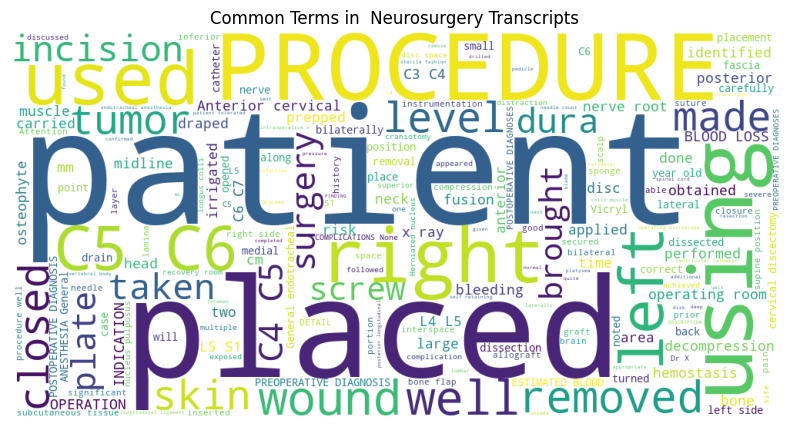

In [2]:
try:
    speciality = ' Neurosurgery'
    if speciality in df['medical_specialty'].values:
        texts = df[df['medical_specialty']==speciality]['transcription']
        if not texts.empty:
            text = ' '.join(texts.astype(str))
            if len(text.strip()) > 0:
                wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
                plt.figure(figsize=(10,5))
                plt.imshow(wordcloud)
                plt.axis("off")
                plt.title(f"Common Terms in {speciality} Transcripts")
                plt.show()
    
            else:
                print(f"No valid text found for {speciality}")
        else:
            print(f"No transcriptions available for {speciality}")
    else:
        print("Speciality not found in dataset")

except Exception as e:
    print("Error:", str(e))

In [3]:
import re
import nltk
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


nltk.download(['stopwords', 'punkt'], quiet=True)

def clean_text(text):
    if not isinstance(text, str):
        return ""

    medical_terms = {
        'dr', 'pt', 'mr', 'mri', 'ct', 'hr', 'bp', 'rr', 'spo2', 
        'ekg', 'cbc', 'er', 'or', 'ed', 'icu', 'lab'
    }
    try:
        text = text.lower()
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\b\d+[\.\d]*\b', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
    
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english')) - medical_terms
        filtered_words = []

        for word in words:
            if word not in stop_words and len(word)>1:
                filtered_words.append(word)

        words = filtered_words

        return ' '.join(words)
        
    except Exception as e:
        print(f'Error while processing the text!: {e}')

tqdm.pandas(desc="Cleaning Text")

df['clean_text'] = df['transcription'].progress_apply(clean_text)

empty_text = df['clean_text'].str.strip().eq('').sum()

print(f"\nDiagnostics:")
print(f" Original samples: {len(df)}")
print(f" Empty results: {empty_text} ({empty_text/len(df):.1%})")
print("\nSample Before:\n", df['transcription'].iloc[0][:200])
print("\nSample After:\n", df['clean_text'].iloc[0][:200])
        

Cleaning Text: 100%|██████████████████████████████████████████████████████████████| 4999/4999 [00:21<00:00, 230.24it/s]


Diagnostics:
 Original samples: 4999
 Empty results: 33 (0.7%)

Sample Before:
 SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried 

Sample After:
 subjective year old white female presents complaint allergies used allergies lived seattle thinks worse past tried claritin zyrtec worked short time seemed lose effectiveness used allegra also used la


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

top_specialties = df['medical_specialty'].value_counts().head(5).index.tolist()

df_top_specialties = df[df['medical_specialty'].isin(top_specialties)].copy()

if len(df_top_specialties) < 150:
    print(f"Insufficient data. Size = {len(df_top_specialties)}")

word_vectorizer = TfidfVectorizer(max_features=750, stop_words='english')

X = word_vectorizer.fit_transform(df_top_specialties['clean_text'])
y = df_top_specialties['medical_specialty']

# Splitting the filtered dataset df_top_specialties into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=36)

model = MultinomialNB()

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

print(f"Classification Report: \n{classification_report(y_test, y_predicted)}")

Classification Report: 
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.60      0.36      0.45        25
 Consult - History and Phy.       0.66      1.00      0.79        21
                 Orthopedic       0.42      0.44      0.43        18
                  Radiology       0.62      0.83      0.71        12
                    Surgery       0.80      0.71      0.75        55

                   accuracy                           0.66       131
                  macro avg       0.62      0.67      0.63       131
               weighted avg       0.67      0.66      0.65       131



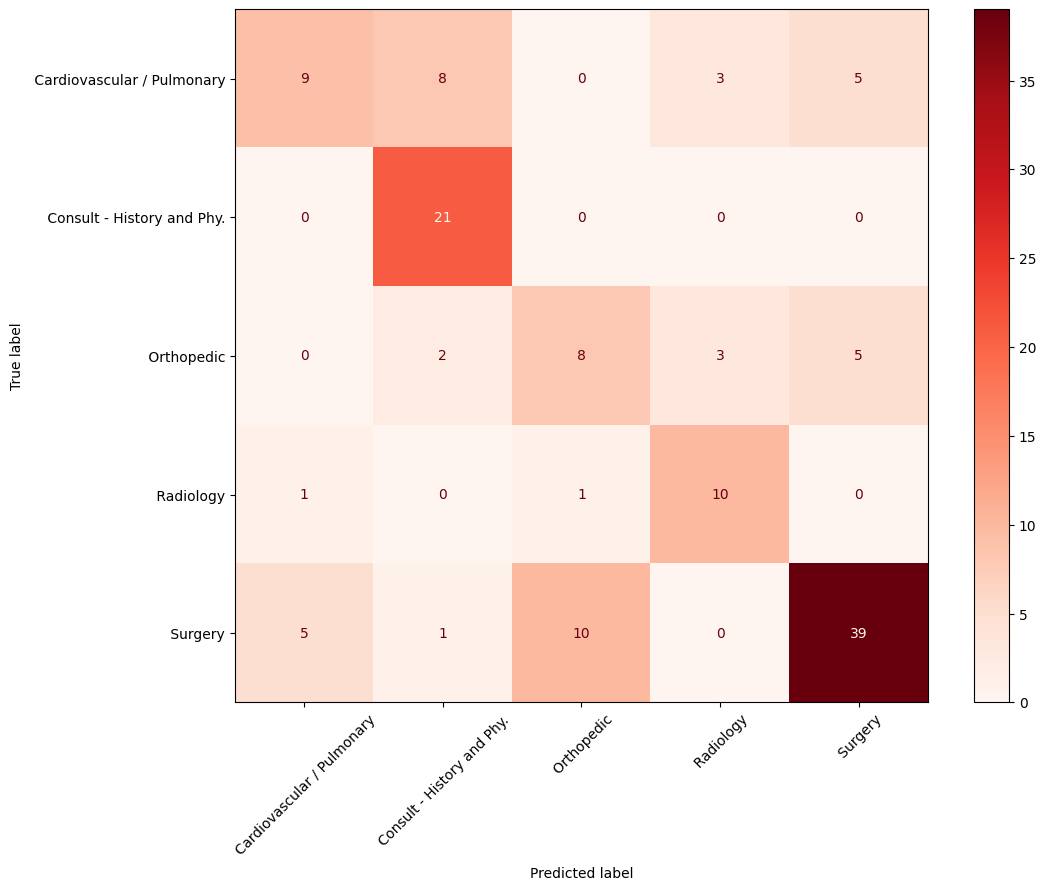

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_predicted,
    display_labels=model.classes_,
    xticks_rotation=45,
    cmap='Reds',
    ax=ax)